In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.0 MB/s 


In [ ]:
import pandas as pd
import tensorflow as tf
from dateutil.parser import parse
dateparse=lambda dates:parse(dates)

from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

import IPython
import IPython.display

from sklearn.metrics import mean_squared_error
import shap
import seaborn as sns; sns.set_theme()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
df = pd.read_csv ('drive/MyDrive/Data/weekly_features.csv')
df = df.drop (columns = ['Unnamed: 0','USD_PHP Historical Data.csv'])
dates = df.year*100+df.week
df['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
mask = (df['Date'] >'1990-09-30') & (df['Date'] <= '2021-09-30')
df= df.loc[mask]
df = df.fillna(method='ffill')

def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(x.to_datetime().timetuple())

# https://www.aiproblog.com/index.php/2018/08/21/4-common-machine-learning-data-transforms-for-time-series-forecasting/
# difference dataset
diff_df=df.drop(columns=['Date', 'year', 'week'])
diff_df = diff_df.diff()
diff_df = diff_df.iloc[1:]
diff_df['year']=df.year[1:]
diff_df['week']=df.week[1:]
#diff_df['Date']=df.Date[1:]
#diff_df['Date'] = pd.to_datetime(diff_df['Date'])
# convert date to timestamp
#diff_df['Date'] = diff_df['Date'].map(pd.Timestamp.timestamp)

#split the data into training and testing dataset
column_indices = {name: i for i, name in enumerate(diff_df.columns)}

n = len(diff_df)
train_df = diff_df[0:int(n*0.7)]
test_df = diff_df[int(n*0.7):]

num_features = diff_df.shape[1]

#Normalize the data
from sklearn.preprocessing import MinMaxScaler
#col_list = [i for i in diff_df.columns if i != 'Date']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

In [ ]:
raw_values = df.drop(columns=['Date'])
#raw_values = df.drop(columns=['year','week'])
#raw_values['Date'] = pd.to_datetime(raw_values['Date'])
# convert date to timestamp
#raw_values['Date'] = raw_values['Date'].map(pd.Timestamp.timestamp)

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
contribution_5_list={}
contribution_10_list={}
contribution_15_list={}
contribution_20_list={}
f_list = [5,6,7,8]

In [ ]:
for i in f_list:

  past_history = 20
  batch_size = 32
  future_target = 20
  STEP = 1
  X_multi, y_multi = multivariate_data(scaled_train, scaled_train[:,i], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)

  X_test_multi, y_test_multi = multivariate_data(scaled_test, scaled_test[:,i], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
  test_data_multi= tf.data.Dataset.from_tensor_slices((X_test_multi, y_test_multi))
  test_data_multi = test_data_multi.batch(batch_size).repeat()


  multi_lstm_cnn = tf.keras.Sequential([
      tf.keras.layers.LSTM(224,input_shape= (past_history,num_features), return_sequences=True),
      tf.keras.layers.Dropout(rate = 0.55),
      tf.keras.layers.LSTM(96,input_shape= (past_history,num_features), return_sequences=True),
      tf.keras.layers.Dropout(rate = 0.15),
      tf.keras.layers.Conv1D(filters=224, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=1),
      tf.keras.layers.Dropout(rate = 0.65),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(448, activation='relu'),
      tf.keras.layers.Dense(future_target, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
  ])

  multi_lstm_cnn.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.MeanSquaredError()])
  history = multi_lstm_cnn.fit(X_multi, y_multi, batch_size=batch_size, epochs=80)

  e = shap.DeepExplainer(multi_lstm_cnn, X_multi[:500,:,:])
  shap_val = e.shap_values(X_test_multi[0:24,:,:])

  features = ['Maximum Temperature','Minimum Temperature','Total Precipitation','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','Snow Fall','Snow Depth','week']

  shap_val = np.array(shap_val)
  shap_abs = np.absolute(shap_val)
#add the prediction together, using absolute shape value
  sum_0 = np.sum(shap_abs,axis=0)
  sum_1 = np.sum(shap_val, axis=0)

  mean_samples = np.mean(sum_0, axis = 0)
  mean_input = np.mean(mean_samples, axis = 0)
  col_name = features[i]
  contribution_20_list[col_name] = mean_input

Train on 1109 samples
Epoch 1/80
1109/1109 [==============================] - 3s 3ms/sample - loss: 0.1248 - mean_squared_error: 0.1238
Epoch 2/80
1109/1109 [==============================] - 2s 2ms/sample - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 3/80
1109/1109 [==============================] - 2s 2ms/sample - loss: 0.0087 - mean_squared_error: 0.0088
Epoch 4/80
1109/1109 [==============================] - 2s 2ms/sample - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 5/80
1109/1109 [==============================] - 2s 2ms/sample - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 6/80
1109/1109 [==============================] - 2s 2ms/sample - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 7/80
1109/1109 [==============================] - 2s 2ms/sample - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 8/80
1109/1109 [==============================] - 2s 2ms/sample - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 9/80
1109/1109 [==============================] - 2s 2ms/sam

In [ ]:
five_step=pd.DataFrame(data =np.array(list(contribution_5_list.values())).reshape(4,17), columns = ['Maximum Temperature','Minimum Temperature','Total Precipitation','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','Snow Fall','Snow Depth','week'])
#Ten_step=pd.DataFrame(data =np.array(list(contribution_10_list.values())).reshape(4,17), columns = ['Maximum Temperature','Minimum Temperature','Total Precipitation','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','Snow Fall','Snow Depth','week'])
#fifteen_step=pd.DataFrame(data =np.array(list(contribution_15_list.values())).reshape(4,17), columns = ['Maximum Temperature','Minimum Temperature','Total Precipitation','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','Snow Fall','Snow Depth','week'])
twenty_step=pd.DataFrame(data =np.array(list(contribution_20_list.values())).reshape(4,17), columns = ['Maximum Temperature','Minimum Temperature','Total Precipitation','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','Snow Fall','Snow Depth','week'])

In [ ]:
five_step.to_csv('drive/MyDrive/Data/five_step_feature_contribution.csv')
#Ten_step.to_csv('drive/MyDrive/Data/Ten_step_feature_contribution.csv')
#fifteen_step.to_csv('drive/MyDrive/Data/fifteen_step_feature_contribution.csv')
twenty_step.to_csv('drive/MyDrive/Data/twenty_step_feature_contribution.csv')

In [ ]:
five_step = pd.read_csv('drive/MyDrive/Data/five_step_feature_contribution.csv')

In [ ]:
five_step = five_step.transpose()
five_step = five_step.to_dict('dict')
five_step['Oats'] = five_step.pop(0)
five_step['Corn'] = five_step.pop(1)
five_step['Soybeans'] = five_step.pop(2)
five_step['Wheat'] = five_step.pop(3)

In [ ]:
Ten_step = Ten_step.transpose()
Ten_step = Ten_step.to_dict('dict')
Ten_step['Oats'] = Ten_step.pop(0)
Ten_step['Corn'] = Ten_step.pop(1)
Ten_step['Soybeans'] = Ten_step.pop(2)
Ten_step['Wheat'] = Ten_step.pop(3)

In [ ]:
fifteen_step = fifteen_step.transpose()
fifteen_step = fifteen_step.to_dict('dict')
fifteen_step['Oats'] = fifteen_step.pop(0)
fifteen_step['Corn'] = fifteen_step.pop(1)
fifteen_step['Soybeans'] = fifteen_step.pop(2)
fifteen_step['Wheat'] = fifteen_step.pop(3)

In [ ]:
twenty_step = twenty_step.transpose()
twenty_step = twenty_step.to_dict('dict')
twenty_step['Oats'] = twenty_step.pop(0)
twenty_step['Corn'] = twenty_step.pop(1)
twenty_step['Soybeans'] = twenty_step.pop(2)
twenty_step['Wheat'] = twenty_step.pop(3)

In [ ]:
five_step = pd.read_csv('drive/MyDrive/Data/five_step_feature_contribution.csv')
Ten_step = pd.read_csv('drive/MyDrive/Data/Ten_step_feature_contribution.csv')
fifteen_step = pd.read_csv ('drive/MyDrive/Data/fifteen_step_feature_contribution.csv')
twenty_step= pd.read_csv('drive/MyDrive/Data/twenty_step_feature_contribution.csv')
five_step = five_step.drop(columns = ['Unnamed: 0'])
Ten_step = Ten_step.drop(columns = ['Unnamed: 0'])
fifteen_step = fifteen_step.drop(columns = ['Unnamed: 0'])
twenty_step = twenty_step.drop(columns = ['Unnamed: 0'])

In [ ]:
features = ['tmax','tmin','prcp','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','SNOW','SNWD','week']

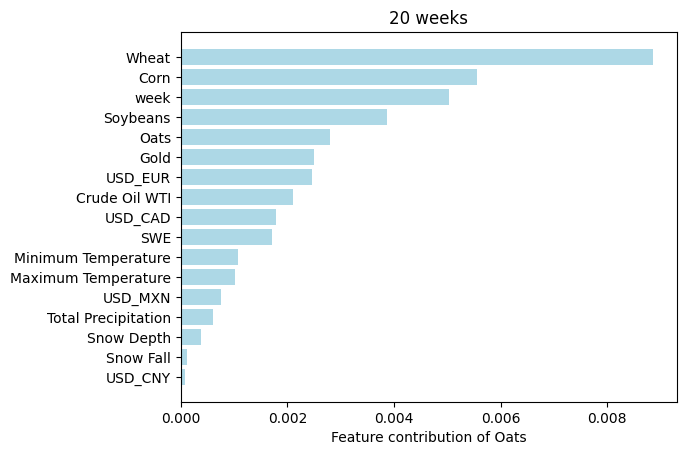

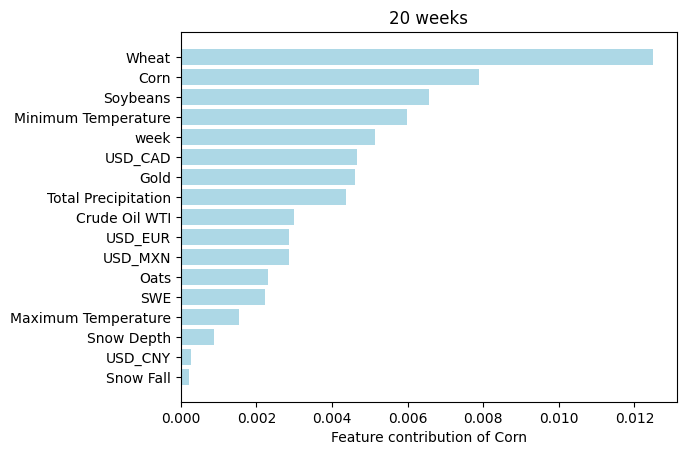

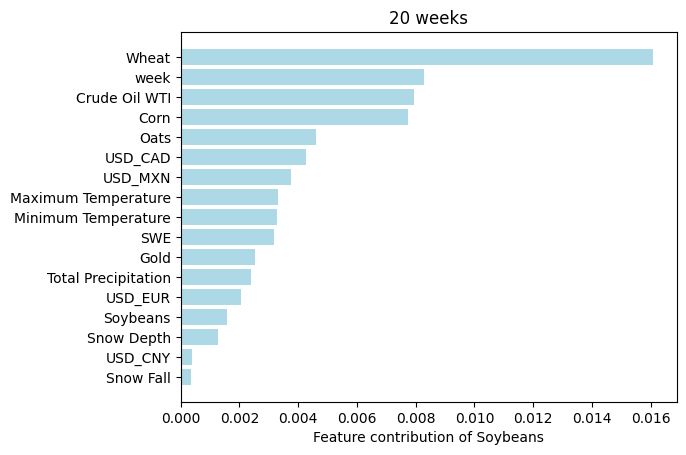

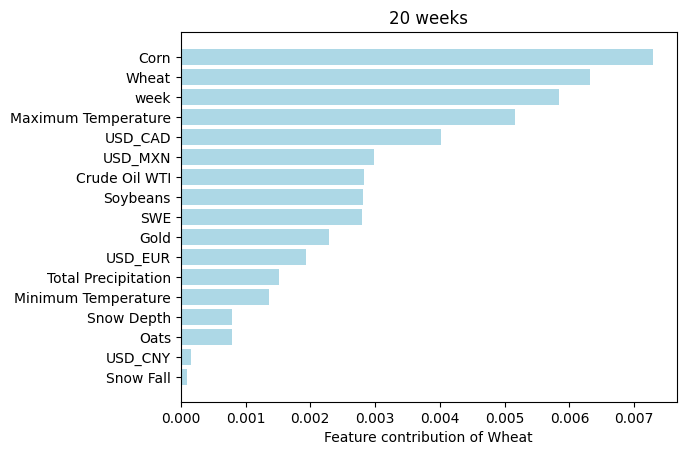

In [ ]:
for name, dict_ in twenty_step.items():
  data = sorted(twenty_step[name].items(), key=lambda x: x[1],reverse=True)
  data = pd.DataFrame(data = data)
  data = data.transpose()
  data.columns = data.iloc[0]
  plt.rcdefaults()
  fig, ax = plt.subplots()
  y_pos = np.arange(len(features))
  ax.barh(y_pos, data.iloc[1], align='center', color = 'lightblue')
  ax.set_yticks(y_pos)
  ax.set_yticklabels(data.columns)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Feature contribution of '+name)
  ax.set_title('20 weeks')
  plt.savefig('drive/MyDrive/Data/Figure/feature_contribution_20_step'+name+'.png', bbox_inches = "tight", dpi=600)
  plt.show()

In [ ]:
contribution_5_list

{'Corn': array([1.17037045e-03, 1.79154830e-03, 5.10693428e-04, 5.05696701e-04,
        6.62708993e-04, 1.28665586e-03, 1.05782070e-03, 1.67376986e-03,
        2.63193331e-03, 6.24627609e-04, 4.41518127e-05, 6.76950214e-04,
        3.31338111e-04, 8.23380800e-04, 5.00631730e-05, 3.69895651e-04,
        2.21196867e-03]),
 'Oats': array([1.42754010e-03, 9.04661764e-04, 4.19633808e-04, 1.17309655e-03,
        1.28109887e-03, 1.55030641e-03, 1.22172020e-03, 5.97437889e-04,
        2.18028588e-03, 8.87821223e-04, 8.91810991e-05, 1.65226900e-03,
        3.18030004e-04, 1.70729741e-03, 3.55006534e-05, 4.28982185e-04,
        4.67204474e-03]),
 'Soybeans': array([1.34342177e-03, 9.17820827e-04, 2.82446311e-03, 2.21795680e-03,
        7.91597247e-04, 1.26699164e-03, 3.41268559e-03, 2.31495269e-03,
        6.79439091e-03, 2.31294141e-03, 7.82569565e-05, 8.93264726e-04,
        1.14141025e-03, 1.15260738e-03, 1.17351418e-04, 6.54252187e-04,
        2.88585757e-03]),
 'Wheat': array([9.70750553e-0

In [ ]:
contribution_10_list

{'Corn': array([0.00113596, 0.003548  , 0.00239638, 0.00210236, 0.00336315,
        0.00174206, 0.0019535 , 0.00195561, 0.00665343, 0.00169163,
        0.00012099, 0.00056448, 0.001599  , 0.00127307, 0.00018407,
        0.00087521, 0.00400528]),
 'Oats': array([1.20342807e-03, 1.44958902e-03, 1.99824648e-03, 3.65694062e-03,
        2.18332832e-03, 2.86112105e-03, 4.45039000e-03, 1.20662635e-03,
        5.48108136e-03, 1.21076142e-03, 1.51584629e-04, 2.91093670e-03,
        1.13747764e-03, 2.70254590e-03, 8.65708563e-05, 7.44616146e-04,
        1.16102790e-02]),
 'Soybeans': array([0.00473113, 0.00335586, 0.00384172, 0.00695548, 0.00325626,
        0.00502023, 0.00898845, 0.00669107, 0.01649402, 0.00471826,
        0.00015574, 0.00073049, 0.00361384, 0.00344958, 0.00037414,
        0.00269104, 0.01579069]),
 'Wheat': array([0.0032628 , 0.0047449 , 0.00203454, 0.00228452, 0.00198836,
        0.00176763, 0.00711176, 0.0042147 , 0.00784848, 0.00304063,
        0.0002284 , 0.00088209, 0.002

In [ ]:
contribution_15_list

{'Corn': array([0.00645006, 0.00353438, 0.00185582, 0.00163896, 0.00236936,
        0.00188068, 0.00462887, 0.00671429, 0.01187818, 0.0033295 ,
        0.00035446, 0.00129546, 0.00256496, 0.00307646, 0.00013159,
        0.00058797, 0.00473477]),
 'Oats': array([0.00276348, 0.00341787, 0.00166116, 0.00504052, 0.00149411,
        0.00486785, 0.00574379, 0.00149456, 0.00735723, 0.00076454,
        0.00027892, 0.00263271, 0.0018087 , 0.00478608, 0.00014045,
        0.00079622, 0.01697531]),
 'Soybeans': array([0.0036247 , 0.00602224, 0.00552243, 0.00668505, 0.0031549 ,
        0.00408531, 0.00749911, 0.00251179, 0.01325009, 0.00399198,
        0.00028769, 0.00156195, 0.00223449, 0.00547628, 0.00033675,
        0.00195481, 0.00665429]),
 'Wheat': array([0.00597985, 0.00783693, 0.00126712, 0.00396875, 0.00318462,
        0.00116981, 0.00919066, 0.00457235, 0.01175098, 0.0038245 ,
        0.00021324, 0.00162605, 0.00344557, 0.00377124, 0.00037958,
        0.00225687, 0.01062535])}

In [ ]:
contribution_20_list

{'Corn': array([0.00499821, 0.00495576, 0.00129249, 0.00097496, 0.00257463,
        0.00211007, 0.01181219, 0.00876915, 0.01539147, 0.00533079,
        0.00020511, 0.00231312, 0.00315159, 0.0028574 , 0.00025562,
        0.00084947, 0.01104712]),
 'Oats': array([0.00333649, 0.00306432, 0.00134474, 0.00241902, 0.00185168,
        0.00484795, 0.0076294 , 0.00302984, 0.01258661, 0.002103  ,
        0.00015174, 0.00360317, 0.00102839, 0.00448575, 0.00015073,
        0.00102956, 0.01602177]),
 'Soybeans': array([0.00494474, 0.00527668, 0.00511591, 0.00699025, 0.00232179,
        0.00583025, 0.00921802, 0.00301346, 0.02140271, 0.00732569,
        0.00020273, 0.00190858, 0.00507735, 0.0043503 , 0.00042843,
        0.00319926, 0.01703774]),
 'Wheat': array([0.00645786, 0.00707368, 0.00191219, 0.0027965 , 0.00343819,
        0.00320175, 0.01120824, 0.00631975, 0.01524729, 0.00550947,
        0.00022021, 0.00307685, 0.0043428 , 0.00555314, 0.00028683,
        0.00295495, 0.0190103 ])}

### local contribution

In [ ]:
past_history = 20
batch_size = 32
future_target = 10
STEP = 1
X_multi, y_multi = multivariate_data(scaled_train, scaled_train[:,8], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)

X_test_multi, y_test_multi = multivariate_data(scaled_test, scaled_test[:,8], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
test_data_multi= tf.data.Dataset.from_tensor_slices((X_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(batch_size).repeat()

multi_lstm_cnn = tf.keras.Sequential([
      tf.keras.layers.LSTM(224,input_shape= (past_history,num_features), return_sequences=True),
      tf.keras.layers.Dropout(rate = 0.55),
      tf.keras.layers.LSTM(96,input_shape= (past_history,num_features), return_sequences=True),
      tf.keras.layers.Dropout(rate = 0.15),
      tf.keras.layers.Conv1D(filters=224, kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=1),
      tf.keras.layers.Dropout(rate = 0.65),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(448, activation='relu'),
      tf.keras.layers.Dense(future_target, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
])
multi_lstm_cnn.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.MeanSquaredError()])
history = multi_lstm_cnn.fit(X_multi, y_multi, batch_size=batch_size, epochs=80)


Train on 1119 samples
Epoch 1/80
1119/1119 [==============================] - 4s 4ms/sample - loss: 0.1355 - mean_squared_error: 0.1354
Epoch 2/80
1119/1119 [==============================] - 2s 2ms/sample - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 3/80
1119/1119 [==============================] - 2s 2ms/sample - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 4/80
1119/1119 [==============================] - 2s 2ms/sample - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 5/80
1119/1119 [==============================] - 2s 2ms/sample - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 6/80
1119/1119 [==============================] - 3s 3ms/sample - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 7/80
1119/1119 [==============================] - 2s 2ms/sample - loss: 0.0078 - mean_squared_error: 0.0077
Epoch 8/80
1119/1119 [==============================] - 3s 3ms/sample - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 9/80
1119/1119 [==============================] - 2s 2ms/sam

In [ ]:
e = shap.DeepExplainer(multi_lstm_cnn, X_multi[:500,:,:])
shap_val = e.shap_values(X_test_multi)

features = ['Maximum Temperature','Minimum Temperature','Total Precipitation','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','Snow Fall','Snow Depth','week']

shap_val = np.array(shap_val)

In [ ]:
mean_shape_val = np.mean(shap_val, axis = 0)

In [ ]:
n0, n1, n2 = np.shape(mean_shape_val)

year_dict = {}
week_dict = {}
for i in range(n0):
  for j in range(n1):
    week = test_df.iloc[i+j].week
    year = test_df.iloc[i+j].year
    data = mean_shape_val[i,j,:]
    if week not in week_dict.keys():
      week_dict[week] = mean_shape_val[i,j,:]
    else:
      week_dict[week] = np.append(week_dict[week], data)
    
    if year not in year_dict.keys():
      year_dict[year] = mean_shape_val[i,j,:]
    else:
      year_dict[year] = np.append(year_dict[year], data)

In [ ]:
for key,item in week_dict.items():
  n = week_dict[key].shape[0]
  d1 = int(n/17)
  week_dict[key]= week_dict[key].reshape((d1,17))
  week_dict[key] = np.mean(week_dict[key],axis=0)

for key,item in year_dict.items():
  n = year_dict[key].shape[0]
  d1 = int(n/17)
  year_dict[key]= year_dict[key].reshape((d1,17))
  year_dict[key] = np.mean(year_dict[key],axis=0)

year_shap = pd.DataFrame.from_dict(year_dict)
week_shap = pd.DataFrame.from_dict(week_dict)

In [ ]:
year_shap.to_csv('drive/MyDrive/Data/wheat_10_year_shap.csv')
week_shap.to_csv('drive/MyDrive/Data/wheat_10_week_shap.csv')

In [ ]:
year_shap = pd.read_csv('drive/MyDrive/Data/wheat_10_year_shap.csv')
week_shap = pd.read_csv('drive/MyDrive/Data/wheat_10_week_shap.csv')

#### use the first 24 samples to examine the feature importance

In [ ]:
year_shap = year_shap.drop(columns=['Unnamed: 0'])
week_shap = week_shap.drop(columns=['Unnamed: 0'])

KeyError: ignored

In [ ]:
year_shap = np.array(year_shap)
year_shap = year_shap.transpose()

In [ ]:
week_shap = np.array(week_shap)
week_shap = week_shap.transpose()

In [ ]:
shap.initjs()
shap.force_plot(e.expected_value[0], year_shap, features)

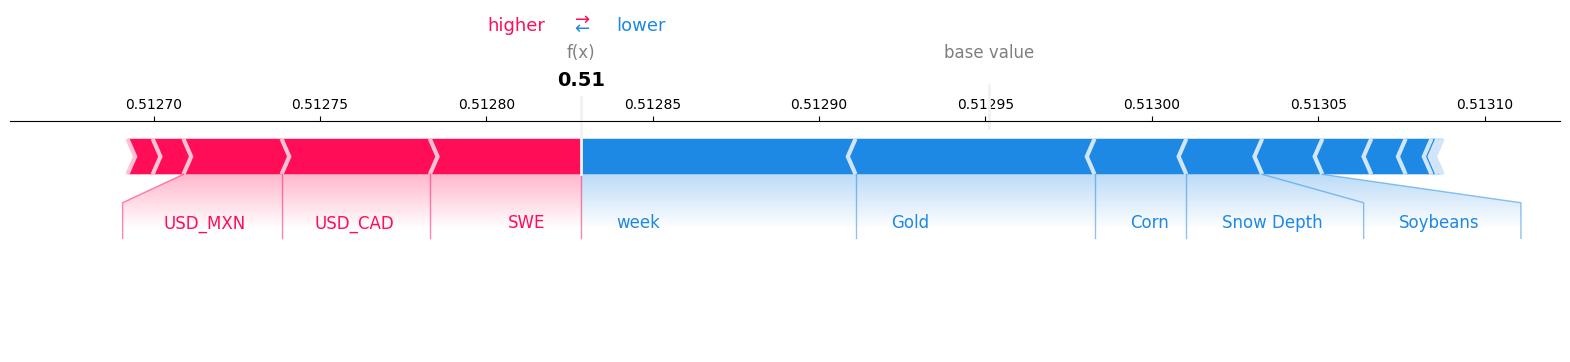

In [ ]:
shap.initjs()
#shap.force_plot(e.expected_value[0], year_shap, features)
shap.force_plot(e.expected_value[0], year_shap[9], features,show=False,matplotlib=True)
plt.savefig('drive/MyDrive/Data/Figure/year_9.png',bbox_inches = "tight")

In [ ]:
features = ['Maximum Temperature','Minimum Temperature','Total Precipitation','Crude Oil WTI', 'Gold','Oats','Corn','Soybeans','Wheat','USD_CAD','USD_CNY','USD_EUR','USD_MXN','SWE','Snow Fall','Snow Depth','week']

In [ ]:
shap.initjs()
shap.force_plot(e.expected_value[0], week_shap, features)